<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Libraries" data-toc-modified-id="Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#The-world-Cup-Problem" data-toc-modified-id="The-world-Cup-Problem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The world Cup Problem</a></span><ul class="toc-item"><li><span><a href="#Exercise-1" data-toc-modified-id="Exercise-1-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Exercise 1</a></span></li><li><span><a href="#Exercise-2" data-toc-modified-id="Exercise-2-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Exercise 2</a></span></li><li><span><a href="#Exercise-3-Probability-of-Superiority" data-toc-modified-id="Exercise-3-Probability-of-Superiority-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exercise 3 Probability of Superiority</a></span></li><li><span><a href="#Predicting-the-rematch" data-toc-modified-id="Predicting-the-rematch-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Predicting the rematch</a></span><ul class="toc-item"><li><span><a href="#Exercise-4" data-toc-modified-id="Exercise-4-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Exercise 4</a></span></li><li><span><a href="#Exercise-5" data-toc-modified-id="Exercise-5-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Exercise 5</a></span></li></ul></li></ul></li></ul></div>

# Introduction
This notebook contains solutions to the [world cup notebook](https://github.com/AllenDowney/BayesMadeSimple/blob/master/05_world_cup.ipynb).


# Libraries

In [1]:
using Gen
using Statistics
using Plots
using DataStructures
using Printf
using StatsPlots

# The world Cup Problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2. Based on this outcome, we can answer the following questions:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance Croatia would win?

To answer these questions, we have to make some modeling assumptions:

1. Goal scoring can be well modeled by a Poisson process, so the distribution of goals scored by each team against the other is Poisson($\lambda$), where $\lambda$ is a goal-scoring rate, measured in goals per game.

2. For two random World Cup teams, the distribution of goal scoring rates is Gamma($\alpha$), where $\alpha$ is a parameter we can choose based on past results.

We will assume $\alpha = 1.4$ per game

## Exercise 1

Not applicable

## Exercise 2

**Question**

Compute posterior distribution for Croatia

**Solution**

Model the goals scored in a game:

In [2]:
@gen function goals_per_game(x::Any)
    goal_score_rate = @trace(gamma(1.4, 1), :goal_score_rate)
    goals = @trace(poisson(goal_score_rate), :goals)
end;

Plot the prior distribution of the goal scoring rate:

In [3]:
function plot_distribution(outcomes::Array{Float64, 1}, title::String)
    
    p = histogram(outcomes, normalize=:probability, legend=false, bins=100)
    xlabel!("Goal scoring rate")
    ylabel!("PMF")
    title!(title)
    
    return p
end;

function plot_distribution(outcomes::Array{Integer, 1}, title::String)
    bins = length(unique(outcomes))
    
    p = histogram(outcomes, normalize=:probability, legend=false, bins=bins)
    xlabel!("Goals scored")
    ylabel!("PMF")
    title!(title)
    
    return p
end;

In [4]:
outcomes = Array{Float64, 1}()
for _ in 1:1000
    trace, _ = Gen.generate(goals_per_game, (nothing,))
    push!(outcomes, trace[:goal_score_rate])
end

┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = traceat(::Gen.GFGenerateState, ::Gen.Gamma, ::Tuple{Float64,Int64}, ::Symbol) at gamma.jl:12
└ @ Gen /opt/julia/packages/Gen/wkcwB/src/modeling_library/gamma.jl:12
┌ Warning: `lgamma(x::Real)` is deprecated, use `(logabsgamma(x))[1]` instead.
│   caller = logpdf at poisson.jl:11 [inlined]
└ @ Core /opt/julia/packages/Gen/wkcwB/src/modeling_library/poisson.jl:11


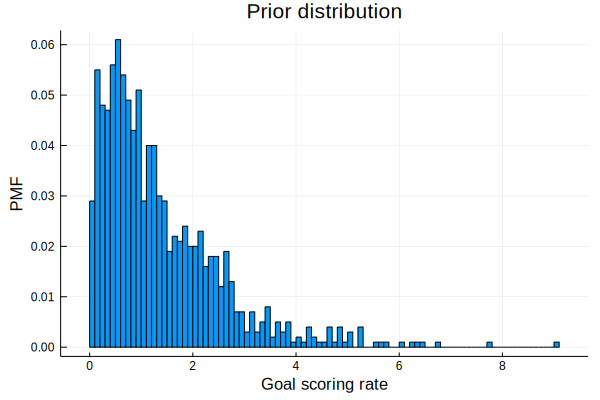

In [5]:
plot_distribution(outcomes, "Prior distribution")

Plot the posterior distribution for France:

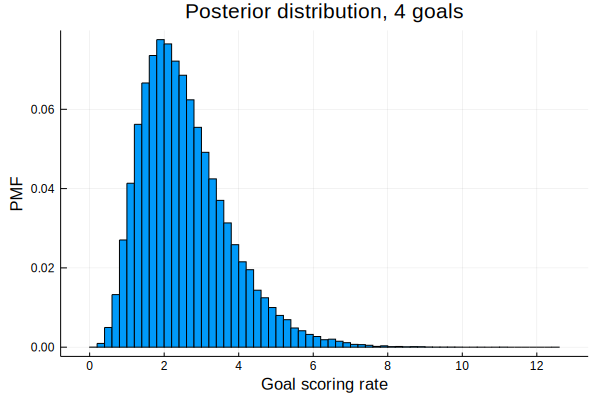

In [6]:
outcomes_france = Array{Float64, 1}()
observations = Gen.choicemap(:goals => 4)

for _ in 1:100000
    trace, _ = Gen.importance_resampling(goals_per_game, (nothing,), observations, 10)
    push!(outcomes_france, trace[:goal_score_rate])
end

plot_distribution(outcomes_france, "Posterior distribution, 4 goals")

Plot the posterior distribution for Croatia:

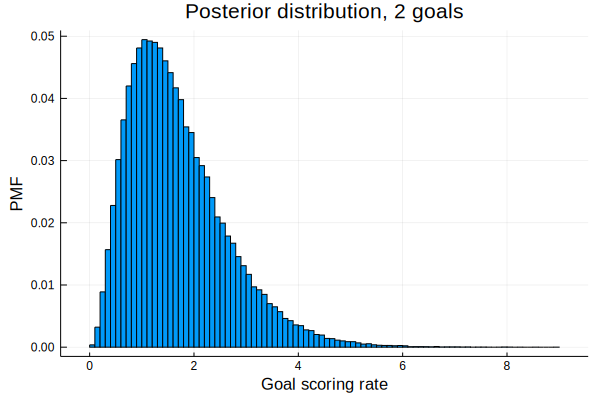

In [7]:
outcomes_croatia = Array{Float64, 1}()
observations = Gen.choicemap(:goals => 2)

for _ in 1:100000
    trace, _ = Gen.importance_resampling(goals_per_game, (nothing,), observations, 10)
    push!(outcomes_croatia, trace[:goal_score_rate])
end

plot_distribution(outcomes_croatia, "Posterior distribution, 2 goals")

## Exercise 3 Probability of Superiority

In the model, "better" means having a higher goal-scoring rate against the opponent. We can use the posterior distributions to compute the "probability of superiority", which is the probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's.

In [8]:
prob_superiority = mean(outcomes_france .> outcomes_croatia)

@sprintf "The probability that France is actually the better team is %.2f" prob_superiority

"The probability that France is actually the better team is 0.73"

## Predicting the rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?

To answer this question, we'll generate a sample from the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, $\lambda$, the distribution of goals would be $Poisson(\lambda)$.

Since we don't know $\lambda$, we can use the sample we generated in the previous section to generate a sample of goals.

The posterior predictive distribution for France is:

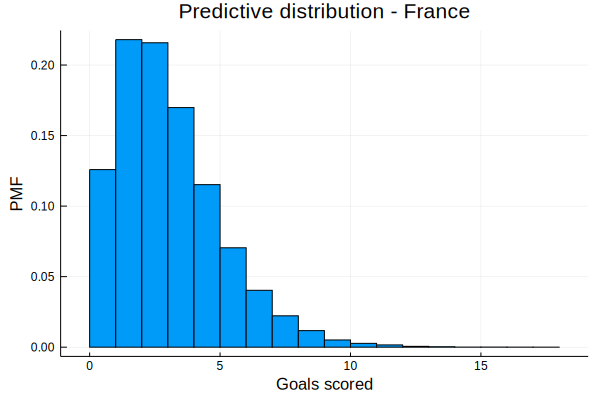

In [9]:
sample_goal_rate_france = outcomes_france
sample_goals_france = Array{Integer, 1}()

for goal_rate in sample_goal_rate_france
    constraint = Gen.choicemap(:goal_score_rate => goal_rate)
    trace, _ = Gen.generate(goals_per_game, (nothing,), constraint)
    push!(sample_goals_france, trace[:goals])
end

plot_distribution(sample_goals_france, "Predictive distribution - France")

### Exercise 4

**Question**

Generate and plot the predictive distribution for Croatia

**Solution**

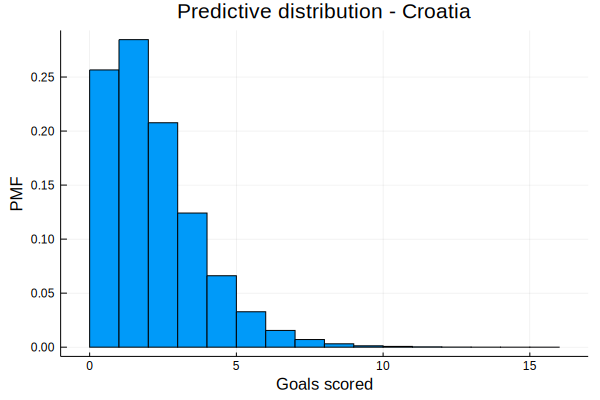

In [10]:
sample_goal_rate_croatia = outcomes_croatia
sample_goals_croatia = Array{Integer, 1}()

for goal_rate in sample_goal_rate_croatia
    constraint = Gen.choicemap(:goal_score_rate => goal_rate)
    trace, _ = Gen.generate(goals_per_game, (nothing,), constraint)
    push!(sample_goals_croatia, trace[:goals])
end

plot_distribution(sample_goals_croatia, "Predictive distribution - Croatia")

### Exercise 5

**Question**

Compute the fraction of simulated rematches Croatia would win, how many France would win, and how many would end in a tie.

**Solution**

In [11]:
function decide_match_outcome(goal_france::Integer, goal_croatia::Integer)::String
    if goal_france > goal_croatia
        return "france win"
    elseif goal_france < goal_croatia
        return "crotia win"
    else
        return "tie"
    end
end

results = [decide_match_outcome(goal_france, goal_croatia) 
           for (goal_france, goal_croatia) in zip(sample_goals_france, sample_goals_croatia)]

num_matches = length(results)

for (k,v) in counter(results)
    out = @sprintf "%s: %.2f" k v/num_matches
    println(out)
end

crotia win: 0.28
france win: 0.55
tie: 0.17
